<>:73: SyntaxWarning: invalid escape sequence '\d'
<>:73: SyntaxWarning: invalid escape sequence '\d'
/var/folders/vt/7xt3j4x53c70jyhvzw06vp8r0000gn/T/ipykernel_13281/4140657788.py:73: SyntaxWarning: invalid escape sequence '\d'
  df_ml['bathrooms'] = df_ml['bathrooms_text'].str.extract('(\d+\.?\d*)').astype(float)


Dataset Loaded: 11744 properties
💰 Calculating Financial Metrics...
✅ Financial metrics calculated.
   - Average ROI across NYC: -14.16%
   - Top 5 ROI Properties:
   roi_percentage  zipcode  price
0      -16.251636    11416   97.0
1      -26.921937    11213  425.0
2      -17.427413    10018  240.0
3      -22.866852    11211   96.0
4      -10.890893    10019  420.0

🤖 Training Price Prediction Model (XGBoost)...
✅ Model Trained.
   - Mean Absolute Error (MAE): $90.94
   - R² Score: 0.514


<Figure size 1000x600 with 0 Axes>

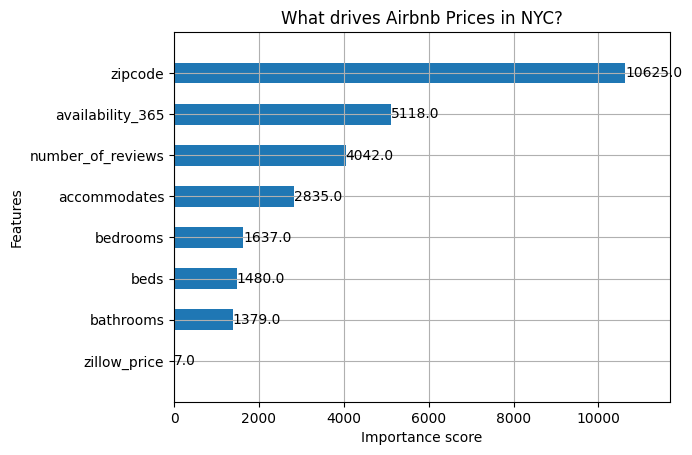

💾 Results saved for Visualization.


In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. LOAD PROCESSED DATA
# ==========================================
df = pd.read_csv('../data/processed/nyc_rental_arbitrage_master.csv')
print(f"Dataset Loaded: {df.shape[0]} properties")

# ==========================================
# 2. FINANCIAL FEATURE ENGINEERING (The BA Logic)
# ==========================================
print("💰 Calculating Financial Metrics...")

# --- A. Revenue Estimation ---
# Heuristic: Occupancy Rate = Reviews/Month * 2 * Min Nights
# We cap occupancy at 70% (0.7) to be conservative
df['occupancy_rate_est'] = df['reviews_per_month'] * 2 * df['minimum_nights'] / 30
df['occupancy_rate_est'] = df['occupancy_rate_est'].clip(upper=0.7)

# Monthly Revenue = Price * Occupancy Rate * 30 days
df['est_monthly_revenue'] = df['price'] * df['occupancy_rate_est'] * 30

# --- B. Cost Estimation ---
# Assumptions
DOWN_PAYMENT_PCT = 0.20
INTEREST_RATE = 0.065 # 6.5% mortgage
LOAN_TERM_YEARS = 30
CLOSING_COSTS = 0.03 # 3% of purchase price

# Monthly Mortgage Calculation (Standard Formula)
P = df['zillow_price'] * (1 - DOWN_PAYMENT_PCT) # Loan Amount
r = INTEREST_RATE / 12
n = LOAN_TERM_YEARS * 12
df['est_monthly_mortgage'] = P * (r * (1 + r)**n) / ((1 + r)**n - 1)

# Monthly Expenses (Maintenance, Taxes, Insurance - Est. 1% of prop value / year)
df['est_monthly_expenses'] = (df['zillow_price'] * 0.01) / 12

# --- C. ROI Calculation (The Holy Grail) ---
# Cash Flow = Revenue - Mortgage - Expenses
df['monthly_cash_flow'] = df['est_monthly_revenue'] - df['est_monthly_mortgage'] - df['est_monthly_expenses']

# Initial Cash Invested = Down Payment + Closing Costs
total_cash_invested = (df['zillow_price'] * DOWN_PAYMENT_PCT) + (df['zillow_price'] * CLOSING_COSTS)

# Cash on Cash ROI = (Annual Cash Flow) / Total Cash Invested
df['roi_percentage'] = (df['monthly_cash_flow'] * 12) / total_cash_invested * 100

print("✅ Financial metrics calculated.")
print(f"   - Average ROI across NYC: {df['roi_percentage'].mean():.2f}%")
print(f"   - Top 5 ROI Properties:\n{df[['roi_percentage', 'zipcode', 'price']].head(5)}")

# ==========================================
# 3. MACHINE LEARNING (Predicting Price)
# ==========================================
print("\n🤖 Training Price Prediction Model (XGBoost)...")

# Define Features (X) and Target (y)
# We use numeric columns + the Zip Code (as a category)
features = ['accommodates', 'bedrooms', 'beds', 'bathrooms_text', 
            'number_of_reviews', 'availability_365', 'zipcode', 'zillow_price']

# Basic cleaning for ML
df_ml = df[features + ['price']].dropna().copy()

# Encode 'bathrooms_text' (Extract numbers, e.g., "1.5 baths" -> 1.5)
df_ml['bathrooms'] = df_ml['bathrooms_text'].str.extract('(\d+\.?\d*)').astype(float)
df_ml = df_ml.drop(columns='bathrooms_text')

# Encode Zipcode (One-Hot or Label Encoding). XGBoost handles 'category' types well.
df_ml['zipcode'] = df_ml['zipcode'].astype('category')

X = df_ml.drop(columns='price')
y = df_ml['price']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost Regressor
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    enable_categorical=True,
    tree_method='hist' # Faster for categorical data
)

# Train
model.fit(X_train, y_train)

# ==========================================
# 4. EVALUATION & INTERPRETATION
# ==========================================
# Predictions
preds = model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f"✅ Model Trained.")
print(f"   - Mean Absolute Error (MAE): ${mae:.2f}")
print(f"   - R² Score: {r2:.3f}")

# Feature Importance Plot
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, max_num_features=10, height=0.5)
plt.title("What drives Airbnb Prices in NYC?")
plt.show()

# ==========================================
# 5. SAVE FINAL DATA FOR DASHBOARD
# ==========================================
# We save the dataframe with ROI columns for the final visualization step
df.to_csv('../data/processed/nyc_rental_arbitrage_results.csv', index=False)
print("💾 Results saved for Visualization.")

🧠 Calculating SHAP Values (This might take a moment)...
✅ SHAP Plot saved to: ../images/shap_summary.png
   - You can now link this image in your README!


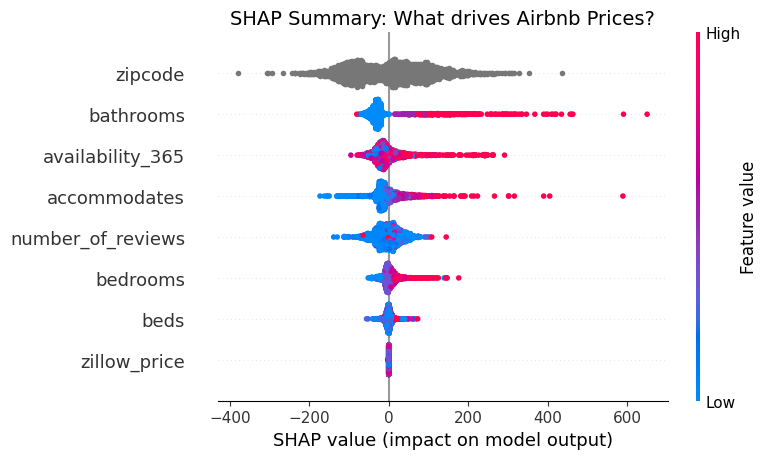

In [2]:
# ==========================================
# 6. SHAP ANALYSIS (Advanced Interpretability)
# ==========================================
import shap

print("🧠 Calculating SHAP Values (This might take a moment)...")

# 1. Initialize the SHAP Explainer
# XGBoost is a tree-based model, so we use TreeExplainer
explainer = shap.TreeExplainer(model)

# 2. Calculate SHAP values for the Test Set
shap_values = explainer(X_test)

# 3. Create the Plot
plt.figure(figsize=(10, 6))
plt.title("SHAP Summary: What drives Airbnb Prices?", fontsize=14)

# Generate the summary plot (The "Beeswarm" plot)
# show=False allows us to save it afterwards
shap.summary_plot(shap_values, X_test, show=False)

# 4. Save the plot for your README
# Make sure the 'images' folder exists first!
import os
if not os.path.exists('../images'):
    os.makedirs('../images')

save_path = '../images/shap_summary.png'
plt.savefig(save_path, bbox_inches='tight', dpi=300)

print(f"✅ SHAP Plot saved to: {save_path}")
print("   - You can now link this image in your README!")